# Example #3: Analyzing experimental data

This notebook will show a brief example of how QMix can be used to analyze experimental data. Note that a wide range of parameters can be passed to these functions in order to import data that has been stored in different formats. Please see [qmix.exp.parameters](https://garrettj403.github.io/QMix/qmix.exp.html#module-qmix.exp.parameters) for a full list of optional keyword arguments.

For the purposes of this notebook, example data has been included in a directory called ``eg-230-data/``. This is experimental data that was taken from an SIS device illuminated by a local-oscillator at 230 GHz (Garrett 2018).

QMix includes two classes that can be used to analyze experimental data:

   - [qmix.exp.RawData0](https://garrettj403.github.io/QMix/qmix.exp.html#qmix.exp.exp_data.RawData0), which is used for DC data (no LO illumination), and
   - [qmix.exp.RawData](https://garrettj403.github.io/QMix/qmix.exp.html#qmix.exp.exp_data.RawData), which is used to analyze pumped data (with LO illumination).

In [1]:
%matplotlib inline

import qmix
import numpy as np
import matplotlib.pyplot as plt

## DC data

This is the data collected from the SIS device with **no local-oscillator (LO) illumination.**

### Properties of the experimental data

The DC experimental data is located in two different files:

   - ``eg-230-data/dciv.csv``: DC tunneling current vs. bias voltage
   - ``eg-230-data/dcif.csv``: IF power vs. bias voltage
   
Both files are CSV files with one column for voltage and one column for current or IF power:

In [2]:
%%bash
head eg-230-data/dciv.csv

DC Bias Voltage (mV), DC Tunneling Current (mA)
0.016102, 0.007249
0.017391, 0.007265
0.019324, 0.007361
0.021257, 0.007378
0.023512, 0.007426
0.026090, 0.007474
0.028345, 0.007587
0.030600, 0.007619
0.032856, 0.007668


In [3]:
%%bash
head eg-230-data/dcif.csv

DC Bias Voltage (mV), IF Power (A.U.)
0.015780, 0.009150
0.017713, 0.009069
0.019968, 0.009101
0.021579, 0.009069
0.023512, 0.009037
0.026412, 0.009005
0.028667, 0.008956
0.030600, 0.009005
0.032856, 0.008988


In order to import these files properly, we will define the properties of the CSV files (which will be passed on to the ``RawData0`` and ``RawData`` classes).

In [4]:
csv_params = dict(delimiter = ',',  # delimiter used by CSV files
                  usecols = (0,1),  # columns to import
                  skip_header = 1,  # skip the first row (the header)
                  v_fmt = 'mV',     # units for voltage data
                  i_fmt = 'mA')     # units for current data

We can also define some of the properties of the junction:

In [5]:
junction_params = dict(area = 1.5,               # area of the junction in um^2
                       vgap_threshold = 105e-6)  # calculate the gap voltage at this current

And some additional properties that will control how the data is filtered:

In [6]:
filter_params = dict(filter_data = True,    # filter I-V data?
                     vgap_guess = 2.75e-3,  # used to temporarily normalize while filtering
                     igap_guess = 2e-4,     # used to temporarily normalize while filtering
                     filter_nwind = 21)     # width of Savitsky-Golay filter

In [7]:
params = {**csv_params, **junction_params, **filter_params}

**Note:** For a full list of keyword arguments, please see the documentation for [qmix.exp.parameters](https://garrettj403.github.io/QMix/qmix.exp.html#module-qmix.exp.parameters).

### Importing DC data

We will now use the ``RawData0`` class to load, filter, and analyze the DC data. It will also automatically correct any offsets in the current or voltage data, calculate the properties of the DC I-V curve, and calculate the IF noise based on the DC shot noise.

In [8]:
dciv = qmix.exp.RawData0('eg-230-data/dciv.csv', 'eg-230-data/dcif.csv', **params)


DC I-V data: 
	Vgap:  		  2.72	mV
	fgap:  		658.44	GHz

	Rn:    		 13.41	ohms
	Rsg:   		365.57	ohms
	Q:     		 27.26

	Jc:    		 13.53	kA/cm^2
	Ileak: 		  8.69	uA

	Offset:		  0.10	mV
	       		  9.68	uA

	Vint:  		  0.45	mV
	IF noise:	  8.71	K



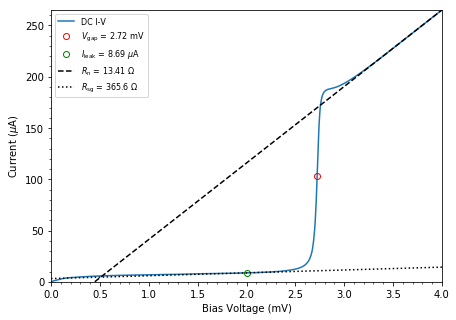

In [9]:
# Plot the DC I-V curve
fig, ax = plt.subplots(figsize=(7,5))
dciv.plot_dciv(ax=ax);

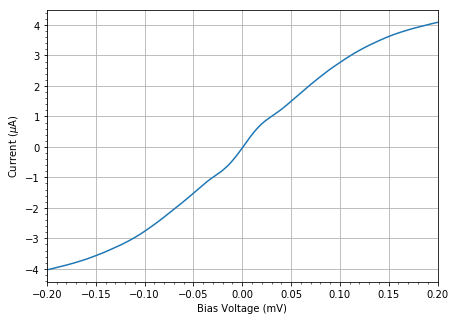

In [10]:
# Plot the origin of the DC I-V curve
# to ensure that all offsets were corrected properly
fig, ax = plt.subplots(figsize=(7,5))
dciv.plot_offset(ax=ax);

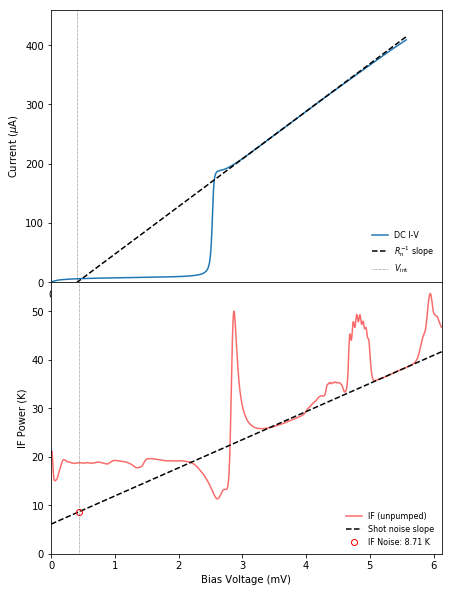

In [11]:
# Plot the IF power
# The linear region above the gap voltage is due to shot noise,
# which can be used to calculate the IF noise contribution
# see Woody (1985)
fig, ax = plt.subplots(2, figsize=(7,10))
dciv.plot_if_noise(ax=ax);

## Pumped Data at 230 GHz

We will now use the ``RawData`` class to import I-V and IF data from the device when it is illuminated by an LO at 230 GHz.

The experimental files are:

- ``f230.2_iv.csv``: the pumped I-V curve
- ``f230.2_if-hot.csv``: the IF power measured with a hot blackbody load
- ``f230.2_if-cold.csv``: the IF power measured with a cold blackbody load

### Importing pumped data

This class will automatically load, filter and analyze the data. This includes calculating the noise temperature and the properties of the embedding circuit.

In [12]:
pump = qmix.exp.RawData('eg-230-data/f230.2_iv.csv', dciv,
                        if_hot_file='eg-230-data/f230.2_if-hot.csv',
                        if_cold_file='eg-230-data/f230.2_if-cold.csv',
                        freq = 230.2,  # LO frequency in [GHz]
                        **params)

Importing: 
 -> Files:
	I-V file:    	eg-230-data/f230.2_iv.csv
	IF hot file: 	eg-230-data/f230.2_if-hot.csv
	IF cold file:	eg-230-data/f230.2_if-cold.csv
 -> Frequency: 230.2 GHz
 -> Impedance recovery:
	- good fit
	- embedding circuit:
		- voltage:     	 +0.53		* Vgap
		- impedance:   	 +0.47-0.30j	* Rn
		- avail. power:	 +41.42		nW
	- junction:
		- drive level:	 +0.93
		- impedance:	 +0.75+0.08j	* Rn
		- deliv. power:	 +38.53		nW
 -> Analyze IF data:
	- noise temp:	  34.5 K
	- gain:		 -1.07 dB



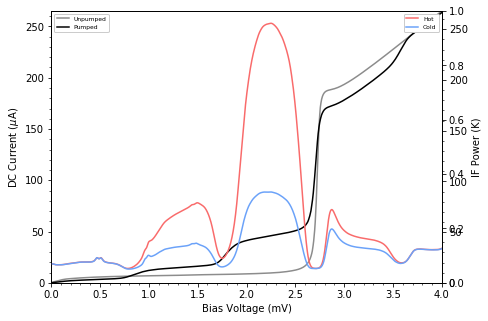

In [13]:
# Plot the I-V curve and the IF powers 
fig, ax1 = plt.subplots(figsize=(7,5))
ax2 = ax1.twinx()
pump.plot_ivif(ax=(ax1,ax2));

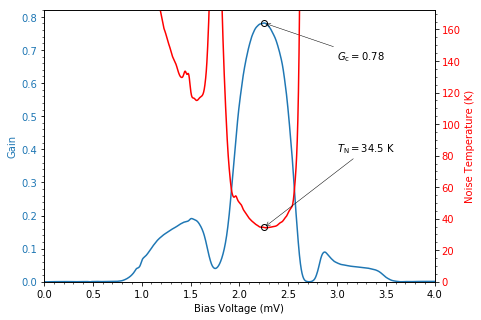

In [14]:
# Plot the noise temperature and gain
fig, ax1 = plt.subplots(figsize=(7,5))
ax2 = ax1.twinx()
pump.plot_gain_noise_temp(ax=(ax1,ax2));

### Impedance recovery

The ``RawData`` class also recovers the embedding circuit using the technique described by Skalare (1989) and Withington *et al.* (1995).

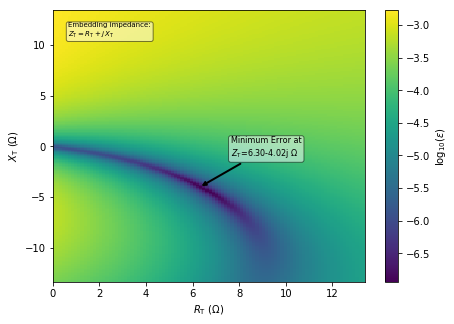

In [15]:
# Plot the error surface
fig, ax = plt.subplots(figsize=(7,5))
pump.plot_error_surface(ax=ax);

This plot was calculated using the error function from Withington *et al.* (1995). The minimum error represents the best impedance estimation.

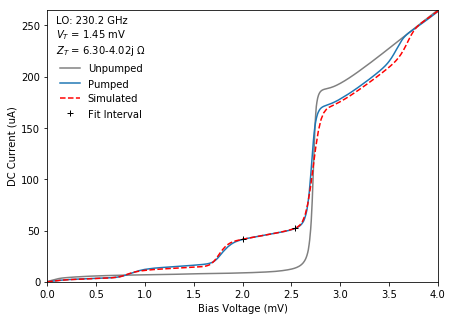

In [16]:
# Plot a simulated I-V curve using the recovered impedance
fig, ax = plt.subplots(figsize=(7,5))
pump.plot_simulated(ax=ax);